# Understanding Hired Rides in NYC

## Dependencies & Setup

In [ ]:
# !pip install --upgrade --force-reinstall \
#     "numpy<2" pandas seaborn matplotlib pillow scipy requests sqlalchemy \
#     geopandas folium beautifulsoup4 contextily networkx 
# !pip install pyarrow python-louvain

In [1]:
import os
import re
import numpy as np
from bs4 import BeautifulSoup
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Any
from scipy.stats import norm
from sklearn.cluster import KMeans
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import sqlalchemy as db
import folium
from datetime import datetime, timedelta
from folium.plugins import HeatMap, DualMap
from PIL import Image
import networkx as nx
import community.community_louvain as community_louvain
import contextily as cx

In [2]:
TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "weather_data"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones
This section loads the taxi zone shapefile to map Location IDs to coordinates.

* `load_taxi_zones`: Reads the shapefile using GeoPandas

* `lookup_coords_for_taxi_zone_id`: Returns coordinates for a given Location ID

* `make_loc_id_coords_dict`: Creates a Location ID–coordinate dictionary for data cleaning

In [5]:
def load_taxi_zones(shapefile: str) -> gpd.GeoDataFrame:
    """
    Load taxi zone shapefile data into a GeoDataFrame.

    Args:
        shapefile (str): Path to the shapefile containing taxi zone geographic data.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the taxi zone data.
    """
    taxi_zones = gpd.read_file(shapefile)
    taxi_zones.to_crs(epsg=CRS, inplace=True)
    return taxi_zones

In [6]:
taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
taxi_zones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
len(taxi_zones)

263

In [8]:
taxi_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((-74.18445 40.695, -74.18449 40.6951,...  
1         Queens  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2          Bronx  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3      Manhattan  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4  Staten Island  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

In [9]:
def lookup_coords_for_taxi_zone_id(zone_loc_id: int) -> Tuple[float, float]:
    """
    Lookup the geographic coordinates for a given taxi zone ID.

    Args:
        zone_loc_id (int): The unique LocationID

    Returns:
        Tuple[float, float]: A tuple of the form (latitude, longitude) of the centroid 
        of the specified taxi zone in the given CRS.
    """
    zone = taxi_zones[taxi_zones["LocationID"] == zone_loc_id]
    centroid = zone.geometry.centroid.iloc[0]
    centroid_geo = gpd.GeoSeries([centroid], crs=taxi_zones.crs).to_crs(epsg=CRS).iloc[0]

    latitude = centroid_geo.y
    longitude = centroid_geo.x

    return (latitude, longitude)

In [10]:
def make_loc_id_coords_dict(loaded_taxi_zones: gpd.GeoDataFrame) -> Dict[int, Dict[str, Any]]:
    """
    Create a dictionary mapping taxi zone LocationIDs to their geographic coordinates and zone names.

    Args:
        loaded_taxi_zones (gpd.GeoDataFrame): GeoDataFrame with taxi zones.

    Returns:
        Dict[int, Dict[str, Any]]: A dictionary where each key is a LocationID (int), and 
        each value is a dict with 'coords': (lat, lon) and 'zone': zone name.
    """
    id_info_dict = {}

    for _, row in loaded_taxi_zones.iterrows():
        loc_id = row["LocationID"]
        zone_name = row["zone"]
        centroid = row["geometry"].centroid
        id_info_dict[loc_id] = {
            "coords": (centroid.y, centroid.x),  # (latitude, longitude)
            "zone": zone_name
        }

    return id_info_dict


In [11]:
ID_COORDS_DICT = make_loc_id_coords_dict(taxi_zones)

### Calculate Sample Size

Because the population is very large, the analysis will use a representative sample from each month to build the dataset. The `calculate_sample_size` function applies Cochran’s formula to determine the appropriate sample size and includes an adjustment for finite populations. This ensures the sample is statistically valid and suitable for the proposed analysis.

In [12]:
def calculate_sample_size(population: int) -> int:
    """
    Calculate the sample size required for a given population size using Cochran's formula
    based on a specified confidence level, margin of error, and proportion. Then adjust the 
    sample size for a finite population.

    Args:
        population (int): Total population size.

    Returns:
        int: The calculated sample size.
    """
    confidence_level = 0.98
    margin_of_error = 0.02
    proportion = 0.5

    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    # Cochran’s
    n = (z_score**2 * proportion * (1 - proportion)) / (margin_of_error**2)
    
    # Adjust for finite population
    n_adj = n / (1 + (n - 1) / population)
    
    return int(round(n_adj)) 

### Common Functions
This section includes functions that automate fetching and preparing the Yellow Taxi trip data. It scrapes and filters the official trip record URLs (January 2020–June 2025), downloads the relevant Parquet files, and organizes them into a directory. Finally, the monthly files are sampled consistently based on the largest dataset size and combined into a single DataFrame for downstream analysis.

In [13]:
def get_all_urls_from_taxi_page(taxi_page: str) -> Tuple[List[str], List[str]]:
    """
    Extract all URLs for Yellow Taxi and High Volume For-Hire Vehicle (FHVHV) trip records.

    Args:
        taxi_page (str): The URL of the taxi page to scrape.

    Returns:
        Tuple[List[str], List[str]]: A tuple containing two lists:
            - List containing URLs for Yellow Taxi trip records.
            - List containing URLs for High Volume For-Hire Vehicle (FHVHV) trip records.
    """
    response = requests.get(taxi_page)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    yellow_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    fhvhv_tags = soup.find_all("a", attrs={"title": "High Volume For-Hire Vehicle Trip Records"})

    yellow_urls = [a["href"].strip() for a in yellow_tags]
    fhvhv_urls = [a["href"].strip() for a in fhvhv_tags]
    
    return yellow_urls, fhvhv_urls

In [14]:
def find_parquet_urls(urls: List[str]) -> List[str]:
    """
    Filters a list of URLs to return only Parquet file URLs.
    
    Args:
        urls (List[str]): A list of URLs.

    Returns:
        List[str]: A list containing with URLs that end with `.parquet`.
    """
    pattern = re.compile(r"\.parquet$")
    parquet_urls = [url for url in urls if pattern.search(url)]    
    return parquet_urls

In [15]:
def download_parquet(urls: List[str], output_dir: str) -> None:
    """
    Downloads Parquet files from a list of URLs and saves them to a specified directory.

    Args:
        urls (List[str]): List of URLs to download.
        output_dir (str): Directory where the downloaded files will be stored.
    """
    os.makedirs(output_dir, exist_ok=True)
    for url in urls:
        filename = os.path.basename(url)
        output_path = os.path.join(output_dir, filename)
        if os.path.exists(output_path):
            continue        
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
        print(f"Downloaded {filename} to {output_dir}")

In [16]:
def get_and_clean_month(urls: List[str]) -> List[str]:
    """
    Filters a list of URLs to include URLs with dates between January 2022 and June 2025.

    Args:
        urls (List[str]): A list of URLs to filter.

    Returns:
        List[str]: A list of filtered URLs.
    """
    pattern = re.compile(r"(202[2-4]-(0[1-9]|1[0-2])|2025-(0[1-6]))")
    cleaned_urls = [url for url in urls if pattern.search(url)]
    return cleaned_urls

In [17]:
def read_parquet_to_df(directory: str) -> Optional[pd.DataFrame]:
    """
    Reads all Parquet files in a directory and concatenates them into a single DataFrame.

    Args:
        directory (str): Path to the directory containing the Parquet files to read.

    Returns:
        Optional[pd.DataFrame]: A combined DataFrame containing data from all Parquet files.
                                Returns None if no Parquet files are found.
    """
    
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    all_dataframe = []
    for file in files:
        
        df = pd.read_parquet(file)
        all_dataframe.append(df)
    if all_dataframe:
        combined_df = pd.concat(all_dataframe, ignore_index=True)
        return combined_df

In [18]:
yellow_urls, fhvhv_urls = get_all_urls_from_taxi_page(TLC_URL)
taxi_parquet = find_parquet_urls(yellow_urls)
uber_parquet = find_parquet_urls(fhvhv_urls)
taxi_urls = get_and_clean_month(taxi_parquet)
uber_urls = get_and_clean_month(uber_parquet)

### Processing Taxi Data

This section downloaded all monthly Yellow Taxi data, created an initial oversample, cleaned it, and then resampled to the final monthly sample size before combining into one DataFrame.

* Calculated monthly sample size using the largest dataset  
* Oversampled **2×** per month to allow removal of invalid data 
 
* The `get_and_clean_taxidata` functions does:  
  - Cleaned invalid Location IDs, missing coordinates, zero‐distance trips  
  - Converted Location IDs to latitude/longitude and filtered trips within NYC bounding box  
  - Merged `"Airport_fee"` columns and computed totals:  
    - `total_surcharge` = extra + improvement_surcharge + congestion_surcharge + airport_fee  
    - `total_money` = fare_amount + total_surcharge + mta_tax + tolls_amount  
    - **Tips excluded** from total fares  
  - Normalized column names, types, and dropped irrelevant columns  
  - Final cleaned monthly samples were resampled to the target size and combined into a single dataset

In [19]:
taxi_data_dir = "taxi_data"
download_parquet(taxi_urls, taxi_data_dir)

In [20]:
def sample_monthly_with_auto_size(directory: str, oversample_factor: int = 2) -> (List[pd.DataFrame], int):
    """
    Determines the sample size based on the largest file, oversamples from each Parquet file,
    and returns a list of sampled DataFrames.

    Args:
        directory (str): Path to the directory containing Parquet files.
        oversample_factor (int): Factor by which to oversample (default = 2).

    Returns:
        List[pd.DataFrame]: List of sampled DataFrames for each month.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    if not files:
        raise ValueError("No Parquet files found in the directory")

    # Determine max rows for sample size calculation
    max_rows = max(pq.ParquetFile(file).metadata.num_rows for file in files)
    sample_size = calculate_sample_size(max_rows)
    print(f"Target sample size per month (after cleaning): {sample_size}")

    # Oversample each month
    sampled_dataframes = []
    for file in files:
        table = pq.read_table(file)
        df = table.to_pandas()
        n = min(sample_size * oversample_factor, len(df))
        sampled_df = df.sample(n=n, random_state=30, replace=False)
        sampled_dataframes.append(sampled_df)

    return sampled_dataframes, sample_size


In [21]:
def get_and_clean_taxidata(dataframes: List[pd.DataFrame], taxi_sample_size: int) -> pd.DataFrame:
    """
    Cleans a list of taxi trip DataFrames, removes invalid trips, performs fare feature engineering 
    (including cbd_congestion_fee), flags trips after CBD fee introduction, and concatenates them 
    into a single cleaned DataFrame.
    """
    print(f"Cleaning and final sampling {len(dataframes)} dataframes...")

    base_columns = [
        "tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_time" ,"trip_distance",
        "PULocationID", "latitude_pickup", "longitude_pickup", 
        "DOLocationID", "latitude_dropoff", "longitude_dropoff",
        "fare_amount", "tip_amount", "total_amount"
    ]
    fare_components = [
        "airport_fee", "congestion_surcharge", "mta_tax", "tolls_amount", 
        "improvement_surcharge", "extra", "cbd_congestion_fee"
    ]
    engineered_cols = ["total_surcharge", "total_fares", "is_post_cbd_fee", "time_period"]

    cleaned_samples = []
    for df in dataframes:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Each item in the list must be a Pandas DataFrame.")

        df.columns = [col.lower().replace(" ", "_") for col in df.columns]

        df[["latitude_pickup", "longitude_pickup"]] = (
            df["pulocationid"]
            .map(lambda loc_id: ID_COORDS_DICT.get(loc_id, {}).get("coords", (np.nan, np.nan)))
            .apply(pd.Series)
        )

        df[["latitude_dropoff", "longitude_dropoff"]] = (
            df["dolocationid"]
            .map(lambda loc_id: ID_COORDS_DICT.get(loc_id, {}).get("coords", (np.nan, np.nan)))
            .apply(pd.Series)
        )

        base_columns = [
            "tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_time", "trip_distance",
            "pulocationid", "latitude_pickup", "longitude_pickup", 
            "dolocationid", "latitude_dropoff", "longitude_dropoff",
            "fare_amount", "tip_amount", "total_amount"
        ]
        fare_components = [
            "airport_fee", "congestion_surcharge", "mta_tax", "tolls_amount", 
            "improvement_surcharge", "extra", "cbd_congestion_fee"
        ]
        engineered_cols = ["total_surcharge", "total_fares", "is_post_cbd_fee", "time_period"]

        columns_to_keep = base_columns + fare_components + engineered_cols


        # Drop invalid rows
        df = df.dropna(subset=["latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff"])
        df = df[df["trip_distance"] > 0]
        df = df[df["trip_distance"] < 1000]

        # Normalize column names
        df.columns = [col.lower().replace(" ", "_") for col in df.columns]

        # Ensure datetime
        df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
        df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

        # Filter trips within bounding box
        ((lat_min, lon_min), (lat_max, lon_max)) = NEW_YORK_BOX_COORDS
        df = df[
            df["latitude_pickup"].between(lat_min, lat_max)
            & df["longitude_pickup"].between(lon_min, lon_max)
            & df["latitude_dropoff"].between(lat_min, lat_max)
            & df["longitude_dropoff"].between(lon_min, lon_max)
        ]
        
        # Merge Airport_fee to airport_fee
        if "Airport_fee" in df.columns:
            df["airport_fee"] = df["Airport_fee"].combine_first(df.get("airport_fee", 0))
            df.drop(columns=["Airport_fee"], inplace=True, errors="ignore")

        # Ensure all fare components exist and fill missing values
        for col in fare_components:
            if col not in df.columns:
                df[col] = 0
            df[col] = df[col].fillna(0)
        
        # Fare calculations
        surcharge_cols = ["extra", "improvement_surcharge", "congestion_surcharge", 
                          "airport_fee", "cbd_congestion_fee", "tolls_amount"]
        df["total_surcharge"] = df[surcharge_cols].sum(axis=1)
        df["total_fares"] = (df["fare_amount"] + df["total_surcharge"] + df["mta_tax"])

        # Remove records with negative fare amounts or total fares
        df = df[(df["fare_amount"] >= 0) & (df["total_fares"] >= 0)]
        
        # Compute trip time in seconds
        df["trip_time"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds()
        df = df[df["trip_time"] > 0]
        
        # Create time period feature indicating late-night or daytime trips
        df["time_period"] = np.where(
            (df["tpep_pickup_datetime"].dt.hour >= 22) | (df["tpep_pickup_datetime"].dt.hour < 4),
            "late-night", "daytime"
        )
        
        n = min(taxi_sample_size, len(df))
        cleaned_samples.append(df.sample(n=n, random_state=30, replace=False))

    # Combine all months
    if cleaned_samples:
        combined_df = pd.concat(cleaned_samples, ignore_index=True)

        # Add CBD congestion fee flag (True for trips after Jan 5, 2025)
        combined_df["is_post_cbd_fee"] = combined_df["tpep_pickup_datetime"] >= pd.to_datetime("2025-01-05")

        # Keep only relevant columns
        combined_df = combined_df[columns_to_keep]

        print(f"✅ Final cleaned dataset shape: {combined_df.shape}")
        return combined_df
    else:
        print("No valid dataframes after cleaning.")
        return pd.DataFrame()


In [22]:
taxi_sampled_dataframes, taxi_sample_size = sample_monthly_with_auto_size(taxi_data_dir, oversample_factor=2)

taxi_data_cleaned = get_and_clean_taxidata(taxi_sampled_dataframes, taxi_sample_size)

Target sample size per month (after cleaning): 3380
Cleaning and final sampling 42 dataframes...
✅ Final cleaned dataset shape: (141960, 24)


In [23]:
taxi_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141960 entries, 0 to 141959
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tpep_pickup_datetime   141960 non-null  datetime64[us]
 1   tpep_dropoff_datetime  141960 non-null  datetime64[us]
 2   trip_time              141960 non-null  float64       
 3   trip_distance          141960 non-null  float64       
 4   pulocationid           141960 non-null  int64         
 5   latitude_pickup        141960 non-null  float64       
 6   longitude_pickup       141960 non-null  float64       
 7   dolocationid           141960 non-null  int64         
 8   latitude_dropoff       141960 non-null  float64       
 9   longitude_dropoff      141960 non-null  float64       
 10  fare_amount            141960 non-null  float64       
 11  tip_amount             141960 non-null  float64       
 12  total_amount           141960 non-null  floa

In [24]:
taxi_data_cleaned.describe()

tpep_pickup_datetime       tpep_dropoff_datetime      trip_time  \
count                      141960                      141960  141960.000000   
mean   2023-10-01 07:10:59.255762  2023-10-01 07:28:17.384052    1038.128290   
min           2022-01-01 00:19:07         2022-01-01 00:24:12       1.000000   
25%           2022-11-14 14:32:40  2022-11-14 14:49:56.250000     466.000000   
50%    2023-09-30 23:56:05.500000  2023-10-01 00:07:28.500000     762.000000   
75%    2024-08-15 20:11:02.750000  2024-08-15 20:24:53.250000    1226.000000   
max           2025-06-30 23:34:33         2025-06-30 23:54:27   86369.000000   
std                           NaN                         NaN    2351.778927   

       trip_distance   pulocationid  latitude_pickup  longitude_pickup  \
count  141960.000000  141960.000000    141960.000000     141960.000000   
mean        3.433005     163.678755        40.751090        -73.965919   
min         0.010000       1.000000        40.576961        -74.174000   
25%         1.100000     132.000000        40.740337        -73.990458   
50%         1.830000     161.000000        40.756729        -73.978492   
75%         3.480000     233.000000        40.768615        -73.965146   
max        44.730000     263.000000        40.899529        -73.726655   
std         4.292940      64.245326         0.032639          0.048716   

        dolocationid  latitude_dropoff  longitude_dropoff  ...   total_amount  \
count  141960.000000     141960.000000      141960.000000  ...  141960.000000   
mean      162.287940         40.753575         -73.971677  ...      26.344439   
min         1.000000         40.561994         -74.174000  ...       0.000000   
25%       113.000000         40.736824         -73.990458  ...      14.760000   
50%       162.000000         40.756729         -73.978492  ...      19.680000   
75%       234.000000         40.773633         -73.961764  ...      28.600000   
max       263.000000         40.899529         -73.726655  ...     271.000000   
std        69.612879          0.032569           0.038016  ...      19.883838   

         airport_fee  congestion_surcharge        mta_tax   tolls_amount  \
count  141960.000000         141960.000000  141960.000000  141960.000000   
mean        0.123109              2.167494       0.496974       0.545224   
min         0.000000              0.000000       0.000000       0.000000   
25%         0.000000              2.500000       0.500000       0.000000   
50%         0.000000              2.500000       0.500000       0.000000   
75%         0.000000              2.500000       0.500000       0.000000   
max         1.750000              2.500000       2.540000      52.600000   
std         0.428547              0.848946       0.039528       2.043677   

       improvement_surcharge          extra  cbd_congestion_fee  \
count          141960.000000  141960.000000       141960.000000   
mean                0.801953       1.358665            0.077562   
min                 0.000000      -0.750000            0.000000   
25%                 0.300000       0.000000            0.000000   
50%                 1.000000       1.000000            0.000000   
75%                 1.000000       2.500000            0.000000   
max                 1.000000      14.250000            0.750000   
std                 0.317073       1.709351            0.228377   

       total_surcharge    total_fares  
count    141960.000000  141960.000000  
mean          5.074007      23.582931  
min           0.000000       0.000000  
25%           3.500000      13.350000  
50%           4.500000      17.800000  
75%           6.000000      25.600000  
max          53.600000     211.310000  
std           3.307093      17.382006  

[8 rows x 22 columns]

### Processing Uber Data
Similar to Taxi data preprocessing, we downloaded all relevant FHVHV data, created an initial sample with filtered Uber data, clean the initial sample, then finally resample to get the desired amout of sample for each month and combine the data into a single dataframe.
* Relevant data are downloaded into the same directory
* Calculated the Uber sample size for each month after filtering Uber rides with `uber_monthly_sample_size`
* Created an initial sample of twice the sample size each month and store the montly samples into separate dataframes. The initial sample was made in order to make sure invalid data points are removed before final sampling, so that the final sample has equal datapoints across months. This was done by `uber_sample_monthly`, and in this function, only certain relevant columns were loaded and stored due to the complexity of FHVHV data attributes would lead to longer run time, and reducing the columns to read effectively speed up later data processing and cleaning.
* The`get_and_clean_uber_data` cleans the initial sample, then resamples cleaned data each month with the pre-computed monthly sample size, and combine the samples to get a single dataframe. The cleaning process includes:
    * Filtered Uber rides
    * Converted Location IDs to latitude lognitude coordinates
    * Computed total fares and surcharges for each ride
        * `total_surcharge` = bcf + congestion_surcharge + airport_fee
        * `total_fare` = base_passenger_fare + surcharge_columns + sales_tax + tolls
        * tips are not included in total fares because it is considered as extra gratuities that is not included in the pricing system
    * Filtered rides that start and/or end within the New York bounding box
    * Dropped columns that are irrelevant to later parts of the project
    * Normalized column names and removed invalid data

In [25]:
uber_data_dir = "uber_data"
download_parquet(uber_urls, uber_data_dir)

In [26]:
def sample_uber_monthly(directory: str, oversample_factor: int = 2) -> (List[pd.DataFrame], int):
    """
    Determines the sample size for Uber rides (HV0003) based on the largest month, 
    then samples from each month's Parquet file.

    Args:
        directory (str): Directory containing Uber FHVHV parquet files.
        oversample_factor (int): Multiplier to oversample initially (for cleaning).

    Returns:
        tuple: (List of sampled monthly DataFrames, target sample size per month)
    """
    # All parquet files
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    if not files:
        raise ValueError(f"No Parquet files found in {directory}")

    # Columns needed for filtering and sampling
    columns_to_load = [
        "hvfhs_license_num", "pickup_datetime", "dropoff_datetime",
        "PULocationID", "DOLocationID", "trip_miles",
        "base_passenger_fare", "bcf", "congestion_surcharge", 
        "airport_fee", "sales_tax", "tolls", "tips"
    ]

    # Step 1: Determine max Uber rows for sample size
    max_rows = 0
    for file in files:
        # Load just license column for speed
        license_col = pd.read_parquet(file, columns=["hvfhs_license_num"])
        num_rows = (license_col["hvfhs_license_num"] == "HV0003").sum()
        max_rows = max(max_rows, num_rows)

    sample_size = calculate_sample_size(max_rows)
    print(f"Target sample size per month: {sample_size}")

    # Step 2: Sample data from each file
    sampled_dataframes = []
    for file in files:
        df = pd.read_parquet(file, columns=columns_to_load)
        filtered_df = df[df["hvfhs_license_num"] == "HV0003"]  # Uber only
        if filtered_df.empty:
            print(f"⚠️ No Uber records in {os.path.basename(file)}")
            continue

        n = min(sample_size * oversample_factor, len(filtered_df))
        sampled_df = filtered_df.sample(n=n, random_state=30, replace=False)
        sampled_dataframes.append(sampled_df)

    return sampled_dataframes, sample_size


In [27]:
def get_and_clean_uber_data(dataframes: List[pd.DataFrame], uber_sample_size: int) -> pd.DataFrame:
    """
    Cleans a list of Uber DataFrames, resamples them based on uber_sample_size,
    and concatenates them into one DataFrame.

    Args:
        dataframes (List[pd.DataFrame]): List of Uber DataFrames to be cleaned and sampled.
        uber_sample_size (int): Number of samples to keep for each DataFrame.

    Returns:
        pd.DataFrame: A cleaned and concatenated DataFrame of sampled Uber data.
    """
    print(f"Cleaning and final sampling {len(dataframes)} dataframes...")

    base_columns = [
        "pickup_datetime", "dropoff_datetime", "trip_time", "trip_miles", 
        "pulocationid", "latitude_pickup", "longitude_pickup", 
        "dolocationid", "latitude_dropoff", "longitude_dropoff",
        "base_passenger_fare", "tips"
    ]
    fare_components = [
        "tolls", "bcf", "congestion_surcharge", "airport_fee", "cbd_congestion_fee", "sales_tax"
    ]
    engineered_cols = ["total_surcharge", "total_fares", "is_post_cbd_fee", "time_period"]

    columns_to_keep = base_columns + fare_components + engineered_cols

    cleaned_samples = []
    for df in dataframes:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Each item in the list must be a Pandas DataFrame.")

        # Normalize column names
        df.columns = [col.lower().replace(" ", "_") for col in df.columns]

        # Lookup coordinates
        df[["latitude_pickup", "longitude_pickup"]] = (
            df["pulocationid"]
            .map(lambda loc_id: ID_COORDS_DICT.get(loc_id, {}).get("coords", (np.nan, np.nan)))
            .apply(pd.Series)
        )

        df[["latitude_dropoff", "longitude_dropoff"]] = (
            df["dolocationid"]
            .map(lambda loc_id: ID_COORDS_DICT.get(loc_id, {}).get("coords", (np.nan, np.nan)))
            .apply(pd.Series)
        )

        # Drop invalid trips
        df = df.dropna(subset=["latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff"])
        df = df[df["trip_miles"] > 0]
        df = df[df["trip_miles"] < 1000]
        
        # Filter trips within bounding box
        ((lat_min, lon_min), (lat_max, lon_max)) = NEW_YORK_BOX_COORDS
        df = df[
            df["latitude_pickup"].between(lat_min, lat_max)
            & df["longitude_pickup"].between(lon_min, lon_max)
            & df["latitude_dropoff"].between(lat_min, lat_max)
            & df["longitude_dropoff"].between(lon_min, lon_max)
        ]

        # Ensure datetime
        df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
        df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

        # Compute trip time
        df["trip_time"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds()
        df = df[df["trip_time"] > 0]

        # Time period feature
        df["time_period"] = np.where(
            (df["pickup_datetime"].dt.hour >= 22) | (df["pickup_datetime"].dt.hour < 4),
            "late-night", "daytime"
        )

        # Fare calculations
        for col in fare_components:
            if col not in df.columns:
                df[col] = 0
            df[col] = df[col].fillna(0)

        surcharge_cols = ["tolls", "bcf", "congestion_surcharge", "airport_fee", "cbd_congestion_fee"]
        df["total_surcharge"] = df[surcharge_cols].sum(axis=1)
        df["total_fares"] = df["base_passenger_fare"] + df["total_surcharge"] + df["sales_tax"]

        # Remove invalid fares
        df = df[(df["total_fares"] >= 0) & (df["base_passenger_fare"] >= 0)]

        # Sampling
        n = min(uber_sample_size, len(df))
        cleaned_samples.append(df.sample(n=n, random_state=30, replace=False))

    if cleaned_samples:
        combined_df = pd.concat(cleaned_samples, ignore_index=True)

        # Add post-CBD congestion fee flag
        combined_df["is_post_cbd_fee"] = combined_df["pickup_datetime"] >= pd.to_datetime("2025-01-05")

        # Final columns
        combined_df = combined_df[columns_to_keep]

        print(f"✅ Final cleaned dataset shape: {combined_df.shape}")
        return combined_df
    else:
        print("No valid dataframes after cleaning.")
        return pd.DataFrame()


In [28]:
uber_sampled_dataframes, uber_sample_size = sample_uber_monthly(uber_data_dir, oversample_factor=2)

uber_data_cleaned = get_and_clean_uber_data(uber_sampled_dataframes, uber_sample_size)

Target sample size per month: 3382
Cleaning and final sampling 42 dataframes...
✅ Final cleaned dataset shape: (142044, 22)


In [29]:
uber_data_cleaned.head()

pickup_datetime    dropoff_datetime  trip_time  trip_miles  \
0 2024-12-01 14:54:58 2024-12-01 15:43:24     2906.0       11.17   
1 2024-12-28 02:36:31 2024-12-28 02:44:58      507.0        1.42   
2 2024-12-18 14:49:29 2024-12-18 14:59:28      599.0        1.46   
3 2024-12-02 12:37:29 2024-12-02 12:54:51     1042.0        1.95   
4 2024-12-16 09:33:48 2024-12-16 09:53:40     1192.0        2.18   

   pulocationid  latitude_pickup  longitude_pickup  dolocationid  \
0           113        40.732579        -73.994305           138   
1           197        40.694542        -73.830924            28   
2           244        40.841709        -73.941399           116   
3           170        40.747746        -73.978492           246   
4            41        40.804334        -73.951292           263   

   latitude_dropoff  longitude_dropoff  ...  tolls   bcf  \
0         40.774376         -73.873629  ...   6.94  1.61   
1         40.711596         -73.808729  ...   0.00  0.27   
2         40.827013         -73.948522  ...   0.00  0.32   
3         40.753309         -74.004015  ...   0.00  0.69   
4         40.778766         -73.951010  ...   0.00  0.56   

   congestion_surcharge  airport_fee  cbd_congestion_fee  sales_tax  \
0                  2.75          0.0                   0       5.81   
1                  0.00          0.0                   0       0.87   
2                  0.00          0.0                   0       1.03   
3                  2.75          0.0                   0       2.23   
4                  2.75          0.0                   0       1.80   

   total_surcharge  total_fares  is_post_cbd_fee  time_period  
0            11.30        75.69            False      daytime  
1             0.27        10.97            False   late-night  
2             0.32        12.95            False      daytime  
3             3.44        30.87            False      daytime  
4             3.31        25.28            False      daytime  

[5 rows x 22 columns]

In [30]:
uber_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142044 entries, 0 to 142043
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pickup_datetime       142044 non-null  datetime64[us]
 1   dropoff_datetime      142044 non-null  datetime64[us]
 2   trip_time             142044 non-null  float64       
 3   trip_miles            142044 non-null  float64       
 4   pulocationid          142044 non-null  int64         
 5   latitude_pickup       142044 non-null  float64       
 6   longitude_pickup      142044 non-null  float64       
 7   dolocationid          142044 non-null  int64         
 8   latitude_dropoff      142044 non-null  float64       
 9   longitude_dropoff     142044 non-null  float64       
 10  base_passenger_fare   142044 non-null  float64       
 11  tips                  142044 non-null  float64       
 12  tolls                 142044 non-null  float64       
 13 

In [31]:
uber_data_cleaned.describe()

pickup_datetime            dropoff_datetime      trip_time  \
count                      142044                      142044  142044.000000   
mean   2023-10-01 07:45:00.415674  2023-10-01 08:03:56.853932    1136.438259   
min           2022-01-01 00:10:04         2022-01-01 00:21:27      14.000000   
25%    2022-11-15 18:34:16.250000  2022-11-15 18:55:50.750000     582.000000   
50%    2023-09-30 23:59:05.500000         2023-10-01 00:18:42     931.000000   
75%    2024-08-16 08:30:16.750000         2024-08-16 08:50:52    1469.000000   
max           2025-06-30 23:39:15         2025-06-30 23:45:49   17857.000000   
std                           NaN                         NaN     787.922709   

          trip_miles   pulocationid  latitude_pickup  longitude_pickup  \
count  142044.000000  142044.000000    142044.000000     142044.000000   
mean        4.533000     138.996931        40.736806        -73.936254   
min         0.010000       1.000000        40.561994        -74.186419   
25%         1.520000      75.000000        40.691507        -73.985156   
50%         2.830000     141.000000        40.737699        -73.949905   
75%         5.820000     211.000000        40.773633        -73.900316   
max       165.360000     263.000000        40.899529        -73.726655   
std         4.527067      74.959793         0.066571          0.065514   

        dolocationid  latitude_dropoff  longitude_dropoff  \
count  142044.000000     142044.000000      142044.000000   
mean      138.195580         40.735971         -73.936195   
min         1.000000         40.561994         -74.186419   
25%        75.000000         40.691507         -73.985156   
50%       138.000000         40.736824         -73.949540   
75%       209.000000         40.773633         -73.899735   
max       263.000000         40.899529         -73.726655   
std        75.242181          0.067167           0.069227   

       base_passenger_fare           tips          tolls            bcf  \
count        142044.000000  142044.000000  142044.000000  142044.000000   
mean             23.689453       0.985398       0.747119       0.674208   
min               0.000000       0.000000       0.000000       0.000000   
25%              11.760000       0.000000       0.000000       0.320000   
50%              18.510000       0.000000       0.000000       0.510000   
75%              29.480000       0.000000       0.000000       0.840000   
max            1436.750000      60.000000      52.060000      40.440000   
std              18.126005       2.778835       2.764744       0.551517   

       congestion_surcharge    airport_fee  cbd_congestion_fee      sales_tax  \
count         142044.000000  142044.000000            142044.0  142044.000000   
mean               1.107599       0.196048                 0.0       2.121425   
min                0.000000       0.000000                 0.0       0.000000   
25%                0.000000       0.000000                 0.0       1.030000   
50%                0.000000       0.000000                 0.0       1.630000   
75%                2.750000       0.000000                 0.0       2.640000   
max                5.500000       7.500000                 0.0     130.520000   
std                1.342734       0.675197                 0.0       1.672941   

       total_surcharge    total_fares  
count    142044.000000  142044.000000  
mean          2.724975      28.535853  
min           0.000000       0.000000  
25%           0.370000      13.940000  
50%           0.980000      21.900000  
75%           3.470000      35.300000  
max          74.320000    1641.590000  
std           3.839788      22.361863

### Processing Weather Data
In this section, we processed the weather data and creates dataframes with hourly and daily granularity information retaining relevant information only.
*  `get_all_weather_csvs` returns the weather csv files in the directory
*  `clean_month_weather_data_hourly` takes csv files and returns a dataframe that contains hourly precipation and hourly wind speed information:
    * The columns and data were converted to appropriate data types, as listed in the docstring
    * In the original data, some entries in `HourlyPrecipitation` are "T" representing trace of rain that is less than 0.01 inch. When cleaning data, "T" were replaced with 0.005, which is the mean value of 0.01 and 0.
    * Normalized column names for readability
    * Filled in missing entries
*  `clean_month_weather_data_daily` takes csv files and returns a dataframe that contains daily precipation, wind speed, and snowfall information.
    * "T" in `DailyPrecipitation` and `DailySnowfall` were replaced with 0.005, similar to hourly data cleaning
*  `load_and_clean_weather_data` concatnates all daily dataframes and all hourly dataframes into two large dataframes that contains all daily weather data and all hourly data respectively.

In [32]:
def get_all_weather_csvs(directory: str) -> list:
    """
    Gets all CSV files from a specified directory.

    Args:
        directory (str): Path to the directory containing weather CSV files.

    Returns:
        list: A list of file paths to all CSV files.
    """    
    weather_csvs = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
    return weather_csvs

#### Daily & Hourly Data Cleaning

In [132]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.DataFrame:
    """
    Cleans and aggregates hourly weather data from a CSV file.

    This function processes a CSV file containing hourly weather data by:
    - Converting the "DATE" column to datetime format.
    - Replacing trace precipitation values ("T") with a small numeric value.
    - Extracting numeric values from the 'HourlyPrecipitation' column, converting them to float.
    - Selecting and renaming relevant columns.
    - Filling missing values with zeros.

    Args:
        csv_file (str): Path to the CSV file containing hourly weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with columns:"date", "hourly_precipitation", "hourly_wind_speed" 
    """
    df = pd.read_csv(csv_file, low_memory=False)
    
    df["date"] = pd.to_datetime(df["DATE"])
    df["HourlyPrecipitation"] = (df["HourlyPrecipitation"]
        .replace("T", "0.005")  # Replace 'T' (trace) with a small float
        .str.extract(r"([\d\.]+)")  # Extract numeric part, ignore non-numeric
        .astype(float) 
    )
    
    # Select and rename
    df = df[["date", "HourlyPrecipitation", "HourlyWindSpeed"]]
    df = df.dropna(subset=["date"])
    df.fillna(0, inplace=True)
    df.rename(columns={
        "HourlyPrecipitation": "hourly_precipitation",
        "HourlyWindSpeed": "hourly_wind_speed"
    }, inplace=True)

    df["date_hour"] = df["date"].dt.floor("h")

    # Aggregate: one row per hour
    df_hourly = (
        df.groupby("date_hour")
        .agg({
            "hourly_precipitation": "sum",
            "hourly_wind_speed": "mean"
        })
        .reset_index()
    )
    
    return df_hourly

In [133]:
def clean_month_weather_data_daily(csv_file: str) -> pd.DataFrame:
    """
    Cleans daily weather data from a CSV file.

    This function processes a CSV file containing daily weather data by:
    - Converting the "DATE" column to datetime format.
    - Replacing trace precipitation and snowfall values ("T") with a small numeric value.
    - Extracting numeric values from the "DailyPrecipitation" and "DailySnowfall" columns and converting them to float.
    - Selecting and renaming relevant columns.
    - Dropping rows with missing values in the specified columns.

    Args:
        csv_file (str): Path to the CSV file containing daily weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with columns: "date", "daily_precipitation",
        "daily_average_wind_speed", "daily_snowfall"
    """
    df = pd.read_csv(csv_file, low_memory=False)
    df["date"] = pd.to_datetime(df["DATE"])

    df["DailyPrecipitation"] = (df["DailyPrecipitation"]
            .replace("T", "0.005")  
            .str.extract(r"([\d\.]+)")  
            .astype(float)  
    )
    df["DailySnowfall"] = (df["DailySnowfall"]
            .replace("T", "0.005")  
            .str.extract(r"([\d\.]+)")  
            .astype(float) 
    )
    
    columns = ["date", "DailyPrecipitation", "DailyAverageWindSpeed", "DailySnowfall"]
    df = df[columns]
    df = df.dropna(subset=columns)
    
    rename_map = {
        "DailyPrecipitation": "daily_precipitation",
        "DailyAverageWindSpeed": "daily_average_wind_speed",
        "DailySnowfall": "daily_snowfall",
    }
    df = df.rename(columns=rename_map)

    return df

In [134]:
def load_and_clean_weather_data() -> (pd.DataFrame, pd.DataFrame):
    """
    Load and clean weather data from CSV files.
    - Retrieves all weather-related CSV files from the WEATHER_CSV_DIR.
    - Cleans the hourly and daily data separately using respective cleaning functions.
    - Combines cleaned data into two DataFrames: one for hourly data and one for daily data.

    Returns:
        tuple: A tuple containing hourly_data and daily_data
    """   
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [135]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [136]:
hourly_weather_data[hourly_weather_data["hourly_precipitation"] > 0.5]

date_hour  hourly_precipitation  hourly_wind_speed
1498 2025-03-05 18:00:00                 2.160           3.000000
1502 2025-03-05 22:00:00                 0.640           8.750000
1503 2025-03-05 23:00:00                 0.710           4.000000
1769 2025-03-17 01:00:00                 0.730           3.750000
1861 2025-03-20 21:00:00                 0.740           3.333333
...                  ...                   ...                ...
7934 2022-11-27 15:00:00                 0.790           7.333333
7939 2022-11-27 20:00:00                 0.570           2.250000
8156 2022-12-06 21:00:00                 1.020           6.000000
8546 2022-12-23 03:00:00                 0.510          10.000000
8547 2022-12-23 04:00:00                 4.645           6.000000

[290 rows x 3 columns]

In [137]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47790 entries, 0 to 8758
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_hour             47790 non-null  datetime64[ns]
 1   hourly_precipitation  47790 non-null  float64       
 2   hourly_wind_speed     47790 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 MB


In [138]:
hourly_weather_data.describe()

date_hour  hourly_precipitation  hourly_wind_speed
count                          47790          47790.000000       47790.000000
mean   2022-10-01 06:03:39.510357760              0.014308           4.582338
min              2020-01-01 00:00:00              0.000000           0.000000
25%              2021-05-12 20:15:00              0.000000           0.000000
50%              2022-09-22 16:30:00              0.000000           5.000000
75%              2024-02-02 18:45:00              0.000000           7.000000
max              2025-08-25 23:00:00              7.560000        2237.000000
std                              NaN              0.126325          14.916047

In [139]:
daily_weather_data.head()

date  daily_precipitation  daily_average_wind_speed  \
41  2025-01-01 23:59:00                0.005                       8.3   
66  2025-01-02 23:59:00                0.000                       9.7   
141 2025-01-05 23:59:00                0.000                       8.6   
180 2025-01-06 23:59:00                0.080                       4.7   
205 2025-01-07 23:59:00                0.000                      12.8   

     daily_snowfall  
41              0.0  
66              0.0  
141             0.0  
180             0.9  
205             0.0

In [140]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1924 entries, 41 to 11637
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1924 non-null   datetime64[ns]
 1   daily_precipitation       1924 non-null   float64       
 2   daily_average_wind_speed  1924 non-null   float64       
 3   daily_snowfall            1924 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 75.2 KB


In [141]:
daily_weather_data.describe()

date  daily_precipitation  \
count                           1924          1924.000000   
mean   2022-10-16 20:32:25.821205504             0.141726   
min              2020-01-01 23:59:00             0.000000   
25%              2021-06-02 17:59:00             0.000000   
50%              2022-10-13 11:59:00             0.000000   
75%              2024-02-09 05:59:00             0.060000   
max              2025-08-24 23:59:00             7.130000   
std                              NaN             0.408220   

       daily_average_wind_speed  daily_snowfall  
count               1924.000000     1924.000000  
mean                   5.039189        0.041068  
min                    0.600000        0.000000  
25%                    3.200000        0.000000  
50%                    4.700000        0.000000  
75%                    6.500000        0.000000  
max                   14.400000       14.800000  
std                    2.367555        0.479657

## Part 2: Storing Cleaned Data

In [142]:
# create a database engine
engine = db.create_engine(DATABASE_URL)

In [143]:
# using SQL define the schemas for various tables in the database.
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather(
    id INTEGER PRIMARY KEY,
    date DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather(
    id INTEGER PRIMARY KEY,
    date DATETIME,
    daily_precipitation FLOAT,
    daily_average_wind_speed FLOAT,
    daily_snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    tpep_pickup_datetime     TIMESTAMP,
    tpep_dropoff_datetime    TIMESTAMP,
    trip_time                FLOAT,    
    trip_distance            FLOAT,
    pulocationid             INTEGER,
    latitude_pickup          FLOAT,
    longitude_pickup         FLOAT,
    dolocationid            INTEGER,
    latitude_dropoff         FLOAT,
    longitude_dropoff        FLOAT,
    fare_amount              FLOAT,
    tip_amount               FLOAT,
    total_amount             FLOAT,
    airport_fee              FLOAT,
    congestion_surcharge     FLOAT,
    mta_tax                  FLOAT,
    tolls_amount             FLOAT,
    improvement_surcharge    FLOAT,
    extra                    FLOAT,
    cbd_congestion_fee       FLOAT,
    total_surcharge          FLOAT,
    total_fares              FLOAT,
    is_post_cbd_fee          BOOLEAN,
    time_period              VARCHAR(20)
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    pickup_datetime         TIMESTAMP,
    dropoff_datetime        TIMESTAMP,
    trip_time               FLOAT,
    trip_miles              FLOAT,
    pulocationid            INTEGER,
    latitude_pickup         FLOAT,
    longitude_pickup        FLOAT,
    dolocationid            INTEGER,
    latitude_dropoff        FLOAT,
    longitude_dropoff       FLOAT,
    base_passenger_fare     FLOAT,
    tips                    FLOAT,
    tolls                   FLOAT,
    bcf                     FLOAT,
    congestion_surcharge    FLOAT,
    airport_fee             FLOAT,
    cbd_congestion_fee      INTEGER,
    sales_tax               FLOAT,
    total_surcharge         FLOAT,
    total_fares             FLOAT,
    is_post_cbd_fee         BOOLEAN,
    time_period             VARCHAR(20)
);

"""

In [144]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [145]:
# create the tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as f:
        schema_sql = f.read()
    schema_stmts = [stmt.strip() for stmt in schema_sql.split(";") if stmt.strip()]
    for stmt in schema_stmts:
        connection.execute(db.text(stmt))

### Add Data to Database

`write_dataframes_to_table` takes a dictionary mapping table names to Pandas DataFrames. It connects to the database and writes each DataFrame to its corresponding table, passing in the dictionary that maps table names to DataFrames, thereby saving the data into the database.

In [146]:
def write_dataframes_to_table(table_to_df_dict: Dict[str, pd.DataFrame]) -> None:
    """
    Write multiple DataFrames to database tables.

    This function takes a dictionary where the keys are table names and the values are the corresponding DataFrames. It writes each DataFrame to the specified database table. If the table already exists, its data will be replaced.

    Parameters:
    table_to_df_dict (dict): A dictionary where keys are table names (strings) and values are the DataFrame objects to be written.

    Returns:
    None

    Exceptions:
    - Raises relevant exceptions if the database connection fails.
    - May raise errors related to data writing if the DataFrame columns do not match the database table columns.
    """
    with engine.connect() as connection:
        for table_name, df in table_to_df_dict.items():
            df.to_sql(table_name, con=connection, if_exists='replace', index=False)


In [147]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data_cleaned,
    "uber_trips": uber_data_cleaned,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [148]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

`write_query_to_file` writes a given SQL query to a specified output file. It constructs the file path using QUERY_DIRECTORY and the outfile name, then writes the query to that file.

In [119]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: str) -> None:
    """
    Write a SQL query to a specified file.

    This function takes a SQL query as a string and writes it to a file in the specified directory. The output file's path is constructed using the predefined QUERY_DIRECTORY.

    Parameters:
    query (str): The SQL query to be written to the file.
    outfile (str): The name of the output file (including the file extension).

    Returns:
    None

    Exceptions:
    - Raises an IOError if the file cannot be opened or written to.
    - Raises a NameError if QUERY_DIRECTORY is not defined.
    """
    query_filepath = os.path.join(QUERY_DIRECTORY, outfile)
    with open(query_filepath, 'w') as f:
        f.write(query)

### 1. Time-of-Day Patterns

#### 1.1 What is the hourly distribution of ride volumes on weekdays vs weekends?
→ (Purpose: identify peaks that may correspond to commuting or social activities)

Compute average number of rides per hour (0–23) separately for weekdays and weekends.

In [51]:
QUERY_MONTHLY_AVG_RIDE_VOLUME_BY_HOUR_FILENAME = "monthly_avg_ride_volume_by_hour.sql"

QUERY_MONTHLY_AVG_RIDE_VOLUME_BY_HOUR = """
SELECT 
    hour,
    day_type,
    AVG(ride_count) AS avg_ride_count
FROM (
    SELECT 
        STRFTIME('%Y-%m', tpep_pickup_datetime) AS month,
        STRFTIME('%H', tpep_pickup_datetime) AS hour,
        CASE 
            WHEN STRFTIME('%w', tpep_pickup_datetime) IN ('0', '6') THEN 'weekend'
            ELSE 'weekday'
        END AS day_type,
        COUNT(*) AS ride_count
    FROM taxi_trips
    GROUP BY month, hour, day_type

    UNION ALL

    SELECT 
        STRFTIME('%Y-%m', pickup_datetime) AS month,
        STRFTIME('%H', pickup_datetime) AS hour,
        CASE 
            WHEN STRFTIME('%w', pickup_datetime) IN ('0', '6') THEN 'weekend'
            ELSE 'weekday'
        END AS day_type,
        COUNT(*) AS ride_count
    FROM uber_trips
    GROUP BY month, hour, day_type
)
GROUP BY hour, day_type
ORDER BY hour, day_type;

"""

df_ride_volume_by_hour = pd.read_sql(QUERY_MONTHLY_AVG_RIDE_VOLUME_BY_HOUR, con=engine)
write_query_to_file(QUERY_MONTHLY_AVG_RIDE_VOLUME_BY_HOUR, QUERY_MONTHLY_AVG_RIDE_VOLUME_BY_HOUR_FILENAME)

In [52]:
fig = px.line(
    df_ride_volume_by_hour,
    x="hour",
    y="avg_ride_count",
    color="day_type",
    markers=True,
    title="Montly Average Ride Volume by Hour: Weekday vs Weekend",
    labels={"hour": "Hour of Day", "ride_count": "Number of Rides", "day_type": "Day Type"},
)

fig.update_layout(
    xaxis=dict(dtick=1),
    template="plotly_white",
    legend_title_text="Day Type"
)

fig.show()


- **Weekday patterns:**
  - Peak at **6 PM** (~164 trips/month), secondary peak at **8 AM** (~127 trips/month), aligned with evening and morning commutes.
  - Ride volume remains consistently high from **7 AM to 11 PM**.

- **Weekend patterns:**
  - Trip volume during weekend is generally significantly lower compared to that during weekdays. Trip volume is more evenly distributed throughout the day, with the lowest volume at 5 PM.
  - **1 AM to 3 AM** is the only period where ride volume is higher than weekdays, possibly due to nightlife.

#### 1.2 How does the temporal ride pattern vary across zones or neighborhoods?

In [53]:
QUERY_RIDE_VOLUME_BY_ZONE_HR_FILENAME = "ride_volume_by_zone_hour.sql"

QUERY_RIDE_VOLUME_BY_ZONE_HR = """
SELECT 
    STRFTIME('%H', tpep_pickup_datetime) AS pickup_hour,
    PULocationID AS pickup_zone_id,
    COUNT(*) AS ride_count,
    'taxi' AS mode
FROM taxi_trips
GROUP BY pickup_hour, pickup_zone_id

UNION ALL

SELECT 
    STRFTIME('%H', pickup_datetime) AS pickup_hour,
    PULocationID AS pickup_zone_id,
    COUNT(*) AS ride_count,
    'uber' AS mode
FROM uber_trips
GROUP BY pickup_hour, pickup_zone_id

ORDER BY pickup_hour, pickup_zone_id, mode;
"""

df_zone_hour = pd.read_sql(QUERY_RIDE_VOLUME_BY_ZONE_HR, con=engine)
write_query_to_file(QUERY_RIDE_VOLUME_BY_ZONE_HR, QUERY_RIDE_VOLUME_BY_ZONE_HR_FILENAME)

In [54]:
# Map zone IDs to names
df_zone_hour["zone_name"] = df_zone_hour["pickup_zone_id"].map(lambda x: ID_COORDS_DICT.get(x, {}).get("zone", "Unknown"))
df_zone_hour.head(5)

# Create a pivot table & normalize by zone
zone_hour_pivot = df_zone_hour.pivot_table(
    index="zone_name",  # or "zone_id" if you prefer
    columns="pickup_hour",
    values="ride_count",
    aggfunc="sum",
    fill_value=0
)

# Normalize by zone (row-wise)
zone_hour_normalized = zone_hour_pivot.div(zone_hour_pivot.sum(axis=1), axis=0)

# Get top 10 zones by total rides
top_zones = df_zone_hour.groupby("zone_name")["ride_count"].sum().nlargest(10).index.tolist()
zone_hour_top10 = zone_hour_normalized.loc[top_zones]

In [55]:
fig = px.imshow(
    zone_hour_top10,
    labels=dict(x="Hour of Day", y="Zone", color="Normalized Ride Volume"),
    x=zone_hour_top10.columns,
    y=zone_hour_top10.index,
    aspect="auto",
    color_continuous_scale="YlGnBu",
    title="Temporal Ride Patterns (Normalized) Across Top Pickup Volume Zones"
)
fig.update_layout(xaxis_nticks=24)
fig.show()


The heatmap displays the top 10 zones in NYC with the highest pickup volumes. To highlight temporal patterns at these high-traffic locations, ride volumes are normalized within each zone, emphasizing relative changes over the 24-hour period.

- **General Daytime Dominance**  
  Most top pickup zones experience higher ride volume during **daytime hours**, especially from **afternoon to early evening (12 PM – 6 PM)**.

- **Zones with Strong Daytime Peaks**  
  - **Midtown Center**  
  - **Upper East Side (South & North)**  
  - **Midtown East**  
  - **Murray Hill**  
  These zones exhibit clear peaks in the afternoon. These zones are business and residential districts, thus high trip volume is likely associated with work commutes and business-related travel.

- **Transport Hubs with Even Distribution**  
  - **JFK Airport**  
  - **Penn Station**  
  Unlike other areas, these transportation hubs, where arrivals and departures occur at all hours, show **relatively flat distribution** of ride volume throughout the day.

- **Evening and Late-Night Activity Zones**  
  - **East Village**: Ride volume **peaks between 7 PM and 2 AM**, suggesting nightlife-driven and dining-hotspot demands.  
  - **Times Square**: Peaks around **9 PM**, with elevated activity from **5 PM to midnight**, reflecting entertainment and tourism dynamics.


#### 1.3 What proportion of rides in each zone occurs during commuter hours vs nightlife hours?

In [56]:
QUERY_RIDE_VOLUME_BY_TIME_MODE_FILENAME = "ride_vol_by_time_mode.sql"

QUERY_RIDE_VOLUME_BY_TIME_MODE = """
WITH time_types AS (
    SELECT 'commuter_morning' AS time_type UNION ALL
    SELECT 'commuter_evening' UNION ALL
    SELECT 'nightlife_evening' UNION ALL
    SELECT 'nightlife_late_night' UNION ALL
    SELECT 'other'
),

combined_rides AS (
    SELECT 
        pulocationid AS pickup_zone_id,
        CAST(STRFTIME('%H', tpep_pickup_datetime) AS INT) AS pickup_hour
    FROM taxi_trips

    UNION ALL

    SELECT 
        pulocationid AS pickup_zone_id,
        CAST(STRFTIME('%H', pickup_datetime) AS INT) AS pickup_hour
    FROM uber_trips
),

categorized_rides AS (
    SELECT 
        pickup_zone_id,
        CASE 
            WHEN pickup_hour BETWEEN 7 AND 10 THEN 'commuter_morning'
            WHEN pickup_hour BETWEEN 16 AND 19 THEN 'commuter_evening'
            WHEN pickup_hour BETWEEN 20 AND 23 THEN 'nightlife_evening'
            WHEN pickup_hour BETWEEN 0 AND 2 THEN 'nightlife_late_night'
            ELSE 'other'
        END AS time_type
    FROM combined_rides
),

ride_counts AS (
    SELECT 
        pickup_zone_id,
        time_type,
        COUNT(*) AS ride_count
    FROM categorized_rides
    GROUP BY pickup_zone_id, time_type
),

zone_ids AS (
    SELECT DISTINCT pickup_zone_id FROM categorized_rides
),

zone_totals AS (
    SELECT 
        pickup_zone_id,
        SUM(ride_count) AS total_rides
    FROM ride_counts
    GROUP BY pickup_zone_id
),

filled_combinations AS (
    SELECT 
        z.pickup_zone_id,
        t.time_type
    FROM zone_ids z
    CROSS JOIN time_types t
)

SELECT 
    f.pickup_zone_id,
    f.time_type,
    COALESCE(r.ride_count, 0) AS ride_count,
    z.total_rides,
    ROUND(CAST(COALESCE(r.ride_count, 0) AS FLOAT) / z.total_rides, 4) AS proportion
FROM filled_combinations f
LEFT JOIN ride_counts r 
    ON f.pickup_zone_id = r.pickup_zone_id AND f.time_type = r.time_type
LEFT JOIN zone_totals z 
    ON f.pickup_zone_id = z.pickup_zone_id
ORDER BY f.pickup_zone_id, f.time_type;
"""

df_time_mode = pd.read_sql(QUERY_RIDE_VOLUME_BY_TIME_MODE, con=engine)
write_query_to_file(QUERY_RIDE_VOLUME_BY_TIME_MODE, QUERY_RIDE_VOLUME_BY_TIME_MODE_FILENAME)

In [57]:
df_time_mode

pickup_zone_id             time_type  ride_count  total_rides  \
0                  1      commuter_evening           0            3   
1                  1      commuter_morning           0            3   
2                  1     nightlife_evening           1            3   
3                  1  nightlife_late_night           0            3   
4                  1                 other           2            3   
...              ...                   ...         ...          ...   
1240             263      commuter_evening         826         3471   
1241             263      commuter_morning         726         3471   
1242             263     nightlife_evening         672         3471   
1243             263  nightlife_late_night         166         3471   
1244             263                 other        1081         3471   

      proportion  
0         0.0000  
1         0.0000  
2         0.3333  
3         0.0000  
4         0.6667  
...          ...  
1240      0.2380  
1241      0.2092  
1242      0.1936  
1243      0.0478  
1244      0.3114  

[1245 rows x 5 columns]

In [58]:
df_time_mode["zone_name"] = df_time_mode["pickup_zone_id"].map(
    lambda x: ID_COORDS_DICT.get(x, {}).get("zone", "Unknown"))

df_time_mode

pickup_zone_id             time_type  ride_count  total_rides  \
0                  1      commuter_evening           0            3   
1                  1      commuter_morning           0            3   
2                  1     nightlife_evening           1            3   
3                  1  nightlife_late_night           0            3   
4                  1                 other           2            3   
...              ...                   ...         ...          ...   
1240             263      commuter_evening         826         3471   
1241             263      commuter_morning         726         3471   
1242             263     nightlife_evening         672         3471   
1243             263  nightlife_late_night         166         3471   
1244             263                 other        1081         3471   

      proportion       zone_name  
0         0.0000  Newark Airport  
1         0.0000  Newark Airport  
2         0.3333  Newark Airport  
3         0.0000  Newark Airport  
4         0.6667  Newark Airport  
...          ...             ...  
1240      0.2380  Yorkville West  
1241      0.2092  Yorkville West  
1242      0.1936  Yorkville West  
1243      0.0478  Yorkville West  
1244      0.3114  Yorkville West  

[1245 rows x 6 columns]

In [59]:
# Define time order (for sorting)
time_order = ["commuter_morning", "commuter_evening", "nightlife_evening", "nightlife_late_night", "other"]

# Convert to categorical — preserve unknown values as NaN temporarily
df_time_mode["time_type"] = pd.Categorical(
    df_time_mode["time_type"], 
    categories=time_order, 
    ordered=True
)

# Add a fallback sort key for time_type (assign unknowns to the end)
df_time_mode["time_type_sort"] = df_time_mode["time_type"].cat.codes

# Now sort without dropping any rows
df_time_mode = df_time_mode.sort_values(["pickup_zone_id", "time_type_sort"]).drop(columns="time_type_sort")
df_time_mode

pickup_zone_id             time_type  ride_count  total_rides  \
1                  1      commuter_morning           0            3   
0                  1      commuter_evening           0            3   
2                  1     nightlife_evening           1            3   
3                  1  nightlife_late_night           0            3   
4                  1                 other           2            3   
...              ...                   ...         ...          ...   
1241             263      commuter_morning         726         3471   
1240             263      commuter_evening         826         3471   
1242             263     nightlife_evening         672         3471   
1243             263  nightlife_late_night         166         3471   
1244             263                 other        1081         3471   

      proportion       zone_name  
1         0.0000  Newark Airport  
0         0.0000  Newark Airport  
2         0.3333  Newark Airport  
3         0.0000  Newark Airport  
4         0.6667  Newark Airport  
...          ...             ...  
1241      0.2092  Yorkville West  
1240      0.2380  Yorkville West  
1242      0.1936  Yorkville West  
1243      0.0478  Yorkville West  
1244      0.3114  Yorkville West  

[1245 rows x 6 columns]

#### 1.4 What is the hour with longest trip duration and trip distance?

In [60]:
QUERY_TRIP_LENGTH_BY_HOUR_FILENAME = "ride_vol_by_time_mode.sql"

QUERY_TRIP_LENGTH_BY_HOUR = """
WITH combined_rides AS (
    SELECT 
        CAST(STRFTIME('%H', tpep_pickup_datetime) AS INT) AS pickup_hour,
        trip_distance,
        trip_time / 60.0 AS trip_time_min,
        'taxi' AS source
    FROM taxi_trips

    UNION ALL

    SELECT 
        CAST(STRFTIME('%H', pickup_datetime) AS INT) AS pickup_hour,
        trip_miles AS trip_distance,
        trip_time / 60.0 AS trip_time_min,
        'uber' AS source
    FROM uber_trips
)

SELECT 
    source,
    pickup_hour,
    COUNT(*) AS total_trips,
    ROUND(AVG(trip_distance), 2) AS avg_distance_miles,
    ROUND(AVG(trip_time_min), 2) AS avg_duration_min
FROM combined_rides
GROUP BY source, pickup_hour
ORDER BY source, pickup_hour;
"""

df_trip_length_hr = pd.read_sql(QUERY_TRIP_LENGTH_BY_HOUR, con=engine)
write_query_to_file(QUERY_TRIP_LENGTH_BY_HOUR, QUERY_TRIP_LENGTH_BY_HOUR_FILENAME)

In [61]:
# df_trip_length_hr

In [62]:
# Prepare separate data for taxi and uber
df_taxi = df_trip_length_hr[df_trip_length_hr["source"] == "taxi"]
df_uber = df_trip_length_hr[df_trip_length_hr["source"] == "uber"]

# Create subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.15,
    subplot_titles=("Average Trip Duration (minutes)", "Average Trip Distance (miles)")
)

# === 1. Duration Plot ===
fig.add_trace(
    go.Scatter(
        x=df_taxi["pickup_hour"],
        y=df_taxi["avg_duration_min"],
        name="Taxi - Duration",
        mode="lines+markers",
        line=dict(dash="solid", color="blue")
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_uber["pickup_hour"],
        y=df_uber["avg_duration_min"],
        name="Uber - Duration",
        mode="lines+markers",
        line=dict(dash="dash", color="blue")
    ),
    row=1, col=1
)

# === 2. Distance Plot ===
fig.add_trace(
    go.Scatter(
        x=df_taxi["pickup_hour"],
        y=df_taxi["avg_distance_miles"],
        name="Taxi - Distance",
        mode="lines+markers",
        line=dict(dash="solid", color="red")
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_uber["pickup_hour"],
        y=df_uber["avg_distance_miles"],
        name="Uber - Distance",
        mode="lines+markers",
        line=dict(dash="dash", color="red")
    ),
    row=2, col=1
)

# === Layout ===
fig.update_layout(
    height=650,
    width=950,
    title="Trip Duration and Distance by Hour of Day (Taxi vs Uber)",
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=1.3
    ),
    margin=dict(t=80),
    xaxis=dict(title="Hour of Day", tickmode="linear", dtick=1, range=[0, 23]),
    xaxis2=dict(title="Hour of Day", tickmode="linear", dtick=1, range=[0, 23])
)

fig.show()


**Trip Duration Trends**

- Both Uber and Taxi exhibit similar hour-by-hour trends throughout the day.
- Duration gradually increases from early morning to late afternoon.
- A peak occurs in the afternoon, likely due to congestion and ride demand, after the peak, ride durations decline into the evening.
- Uber durations are consistently higher than Taxi across all hours, the trend appears as an upward-shifted curve compared to Taxi.

**Trip Distance Trends**

- Similar to duration trends, Uber and Taxi share similar patterns throughout the day.
- A noticeable rise in trip distances occurs during early morning hours, potentially due to airport or long-commute trips.
- Throughout the rest of the day, distances remain relatively stable.
- A slight drop in average distance appears during the evening hours, indicating more local or neighborhood-based rides.
- Uber distances are generally higher than Taxi, mirroring the duration trend.

Uber may attract longer inter-borough trips, while Taxi captures more local and opportunistic passengers, especially during peak traffic hours.

#### 1.5 Fee components by hour

In [63]:
QUERY_FARE_COMPONENTS_BY_HOUR_FILENAME = "fare_components_by_hour.sql"

QUERY_FARE_COMPONENTS_BY_HOUR ="""
WITH individual_fares AS (
    SELECT
        CAST(STRFTIME('%H', tpep_pickup_datetime) AS INT) AS pickup_hour,
        AVG(total_fares) AS avg_total_fares,
        AVG(fare_amount) AS avg_fare_amount,
        AVG(total_surcharge) AS avg_total_surcharge,
        AVG(mta_tax) AS avg_tax
    FROM taxi_trips
    GROUP BY pickup_hour

    UNION ALL

    SELECT
        CAST(STRFTIME('%H', pickup_datetime) AS INT) AS pickup_hour,
        AVG(total_fares) AS avg_total_fares,
        AVG(base_passenger_fare) AS avg_fare_amount,
        AVG(total_surcharge) AS avg_total_surcharge,
        AVG(sales_tax) AS avg_tax
    FROM uber_trips
    GROUP BY pickup_hour
),

combined_avg AS (
    SELECT
        pickup_hour,
        AVG(avg_total_fares) AS avg_total_fares,
        AVG(avg_fare_amount) AS avg_fare_amount,
        AVG(avg_total_surcharge) AS avg_total_surcharge,
        AVG(avg_tax) AS avg_tax
    FROM individual_fares
    GROUP BY pickup_hour
)

SELECT 
    pickup_hour,
    ROUND(100 * avg_fare_amount / avg_total_fares, 2) AS base_fare_pct,
    ROUND(100 * avg_total_surcharge / avg_total_fares, 2) AS surcharge_pct,
    ROUND(100 * avg_tax / avg_total_fares, 2) AS tax_pct
FROM combined_avg
ORDER BY pickup_hour;

"""

df_fare_components_hr = pd.read_sql(QUERY_FARE_COMPONENTS_BY_HOUR, con=engine)
write_query_to_file(QUERY_FARE_COMPONENTS_BY_HOUR, QUERY_FARE_COMPONENTS_BY_HOUR_FILENAME)


In [64]:
# df_fare_components_hr

In [65]:
fig = go.Figure()

# Add base fare
fig.add_trace(go.Bar(
    x=df_fare_components_hr['pickup_hour'],
    y=df_fare_components_hr['base_fare_pct'],
    name='Base Fare %',
    marker_color='steelblue'
))

# Add surcharge
fig.add_trace(go.Bar(
    x=df_fare_components_hr['pickup_hour'],
    y=df_fare_components_hr['surcharge_pct'],
    name='Surcharge %',
    marker_color='orange'
))

# Add tax
fig.add_trace(go.Bar(
    x=df_fare_components_hr['pickup_hour'],
    y=df_fare_components_hr['tax_pct'],
    name='Tax %',
    marker_color='green'
))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Fare Component Percentages by Hour of Day',
    xaxis=dict(
        title='Hour of Day',
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(
        title='Percentage of Total Fare',
        range=[0, 100]
    ),
    height=500,
    template='plotly_white'
)

fig.show()


Relative uniform distribution of the fare component percentages accross hours, slightly higher percentage of surcharges from around 4 PM to 7 PM, possibly related to afternoon congestion.

In [66]:
QUERY_SURCHARGE_COMPONENTS_BY_HOUR_FILENAME = "fare_components_by_hour.sql"

QUERY_SURCHARGE_COMPONENTS_BY_HOUR ="""
WITH individual_fares AS (
    SELECT
        CAST(STRFTIME('%H', tpep_pickup_datetime) AS INT) AS pickup_hour,
        AVG(total_fares) AS avg_total_fares,
        AVG(fare_amount) AS avg_fare_amount,
        AVG(total_surcharge) AS avg_total_surcharge,
        AVG(mta_tax) AS avg_tax
    FROM taxi_trips
    GROUP BY pickup_hour

    UNION ALL

    SELECT
        CAST(STRFTIME('%H', pickup_datetime) AS INT) AS pickup_hour,
        AVG(total_fares) AS avg_total_fares,
        AVG(base_passenger_fare) AS avg_fare_amount,
        AVG(total_surcharge) AS avg_total_surcharge,
        AVG(sales_tax) AS avg_tax
    FROM uber_trips
    GROUP BY pickup_hour
),

combined_avg AS (
    SELECT
        pickup_hour,
        AVG(avg_total_fares) AS avg_total_fares,
        AVG(avg_fare_amount) AS avg_fare_amount,
        AVG(avg_total_surcharge) AS avg_total_surcharge,
        AVG(avg_tax) AS avg_tax
    FROM individual_fares
    GROUP BY pickup_hour
)

SELECT 
    pickup_hour,
    ROUND(100 * avg_fare_amount / avg_total_fares, 2) AS base_fare_pct,
    ROUND(100 * avg_total_surcharge / avg_total_fares, 2) AS surcharge_pct,
    ROUND(100 * avg_tax / avg_total_fares, 2) AS tax_pct
FROM combined_avg
ORDER BY pickup_hour;

"""

df_fare_components_hr = pd.read_sql(QUERY_FARE_COMPONENTS_BY_HOUR, con=engine)
write_query_to_file(QUERY_FARE_COMPONENTS_BY_HOUR, QUERY_FARE_COMPONENTS_BY_HOUR_FILENAME)


### 2. Late-Night Ride investigations
In this section, we are interested in exploring where are people traveling most after midnight? Can we infer hubs of social or labor activity?

#### 2.1 Geospatial distribution of late-night rides

In [67]:
QUERY_LATENIGHT_TRIPS_FILENAME = "late_night_pct_day.sql"

QUERY_LATENIGHT_TRIPS ="""
SELECT 
    latitude_pickup, longitude_pickup,
    latitude_dropoff, longitude_dropoff,
    trip_distance,
    tpep_pickup_datetime AS pickup_datetime,
    tpep_dropoff_datetime AS dropoff_datetime,
    CASE 
      WHEN STRFTIME('%w', tpep_pickup_datetime) IN ('0', '6') THEN 'weekend'
      ELSE 'weekday'
    END AS day_type
FROM taxi_trips
WHERE time_period = "late-night"

UNION ALL

SELECT 
    latitude_pickup, longitude_pickup,
    latitude_dropoff, longitude_dropoff,
    trip_miles AS trip_distance,
    pickup_datetime,
    dropoff_datetime,
    CASE 
      WHEN STRFTIME('%w', pickup_datetime) IN ('0', '6') THEN 'weekend'
      ELSE 'weekday'
    END AS day_type
FROM uber_trips
WHERE time_period = "late-night";
"""

df_late_night_trips = pd.read_sql(QUERY_LATENIGHT_TRIPS, con=engine)
write_query_to_file(QUERY_LATENIGHT_TRIPS, QUERY_LATENIGHT_TRIPS_FILENAME)


In [68]:
# Weekday vs Weekend late-night pickups
weekday_df = df_late_night_trips[df_late_night_trips['day_type'] == 'weekday']
weekend_df = df_late_night_trips[df_late_night_trips['day_type'] == 'weekend']

dual_map = DualMap(location=[40.75, -73.98], zoom_start=10, tiles="CartoDB positron")

# Weekday heatmap
HeatMap(
    data=weekday_df[['latitude_pickup', 'longitude_pickup']],
    radius=9, blur=5
).add_to(dual_map.m1)

# Weekend heatmap
HeatMap(
    data=weekend_df[['latitude_pickup', 'longitude_pickup']],
    radius=9, blur=5
).add_to(dual_map.m2)

dual_map

**Spatial Patterns in Late-Night Pickup Hotspots (10 PM–4 AM)**

Manhattan stands out as the most active borough for late-night ride pickups, especially around mid to lower Manhattan. The Bronx ranks second, showing a moderate level of activity. 

Brooklyn follows closely with more pickups around regions geographically closer to Manhattan. 

Queens shows limited pickup density, except around JFK Airport. 

Staten Island exhibits minimal late-night pickup activity, making it the least active borough in this time window.

**Weekday Trends (Monday–Friday):**

- JFK Airport emerges as a pickup hotspot during weekday late-night hours, reflecting frequent airport transfers after late flights or red-eye departures.

- In Manhattan, pickup activity is more evenly distributed across Midtown, East Village, West Village, and the Financial District—possibly due to a mix of work-related travel, nightlife, and shift work.

**Weekend Trends (Saturday–Sunday):**

- East Village becomes a highly pronounced hotspot on weekends, which might be related to intensified nightlife-related ride demand (e.g., bars, events, late dining).

- Compared to weekdays, there’s a relative decline in airport pickups, and fewer pickups concentrated in Midtown, likely due to reduced business travel.

#### 2.2 Day of week distribution of late-night rides

In [69]:
QUERY_LATE_NIGHT_RIDE_PCT_BY_DAY_FILENAME = "late_night_ride_pct_by_day.sql"

QUERY_LATE_NIGHT_RIDE_PCT_BY_DAY = """
WITH all_rides AS (
    SELECT 
        CAST(STRFTIME('%w', tpep_pickup_datetime) AS INT) AS day_of_week,
        CASE WHEN time_period = "late-night" THEN 1 ELSE 0 END AS is_late
    FROM taxi_trips
    UNION ALL
    SELECT 
        CAST(STRFTIME('%w', pickup_datetime) AS INT) AS day_of_week,
        CASE WHEN time_period = "late-night" THEN 1 ELSE 0 END AS is_late
    FROM uber_trips
)
SELECT 
    day_of_week,
    COUNT(*) AS total_rides,
    SUM(is_late) AS late_rides,
    ROUND(100.0 * SUM(is_late) / COUNT(*), 2) AS late_ride_pct
FROM all_rides
GROUP BY day_of_week
ORDER BY day_of_week;
"""

df_late_night_pct_by_day = pd.read_sql(QUERY_LATE_NIGHT_RIDE_PCT_BY_DAY, con=engine)
write_query_to_file(QUERY_LATE_NIGHT_RIDE_PCT_BY_DAY, QUERY_LATE_NIGHT_RIDE_PCT_BY_DAY_FILENAME)

In [70]:
day_week_map = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}
df_late_night_pct_by_day["day_name"] = df_late_night_pct_by_day["day_of_week"].map(day_week_map)
df_late_night_pct_by_day

day_of_week  total_rides  late_rides  late_ride_pct   day_name
0            0        38211        9521          24.92     Sunday
1            1        35410        4589          12.96     Monday
2            2        38385        4810          12.53    Tuesday
3            3        40304        5459          13.54  Wednesday
4            4        42967        6415          14.93   Thursday
5            5        43585        7973          18.29     Friday
6            6        45142       11190          24.79   Saturday

Sunday and Saturday stand out with the highest proportion of late-night rides, at 24.92% and 24.79% respectively, reflecting increased late-night activity over the weekend.

Friday also shows a moderate rise with 18.29% of rides occurring between 10 PM and 4 AM, consistent with people going out or returning late from evening plans.

On weekdays, late night rides have a noticeably lower proportion compared to the weekends and Fridays. 

#### 2.3 Pickup Dropoff Community Detection

In [71]:
QUERY_RIDE_FLOWS_FILENAME = "all_rides.sql"

QUERY_RIDE_FLOWS = """
-- Late-Night Uber
SELECT 
    pulocationid AS pickup_zone,
    dolocationid AS dropoff_zone,
    'Uber' AS source,
    time_period
FROM uber_trips

UNION ALL

-- Late-Night Taxi
SELECT 
    pulocationid,
    dolocationid,
    'Taxi' AS source,
    time_period
FROM taxi_trips
"""

df_all = pd.read_sql(QUERY_RIDE_FLOWS, con=engine)
write_query_to_file(QUERY_RIDE_FLOWS, QUERY_RIDE_FLOWS_FILENAME)

In [72]:
# Filter by source and time
df_uber_night = df_all[(df_all['source'] == 'Uber') & (df_all['time_period'] == 'late-night')]
df_uber_day  = df_all[(df_all['source'] == 'Uber') & (df_all['time_period'] == 'daytime')]
df_taxi_night = df_all[(df_all['source'] == 'Taxi') & (df_all['time_period'] == 'late-night')]
df_taxi_day  = df_all[(df_all['source'] == 'Taxi') & (df_all['time_period'] == 'daytime')]

The following cell defines functions that build ride flow graphs, perform flow community detection, and further plot out the community detection results. 

In [73]:
def build_od_graph(df_od: pd.DataFrame) -> nx.DiGraph:
    """
    Builds a directed graph from origin-destination DataFrame.

    Args:
        df_od (pd.DataFrame): DataFrame with 'pickup_zone' and 'dropoff_zone' columns.

    Returns:
        nx.DiGraph: Directed graph with zones as nodes and ride counts as edge weights.
    """
    edge_weights = df_od.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='weight')
    G = nx.DiGraph()
    for _, row in edge_weights.iterrows():
        G.add_edge(row['pickup_zone'], row['dropoff_zone'], weight=row['weight'])
    return G

def get_communities(G: nx.DiGraph, resolution=1.5) -> gpd.GeoDataFrame:
    """
    Uses Louvain community detection to identify communities in the graph G.
    
    Args:
        G (nx.DiGraph): Directed graph with zones as nodes and ride counts as edge weights.
        resolution (float, optional): Defaults to 1.6.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame with columns: "zone_id", "community", "zone", "lat", "lon", "geometry"
        Will be used for plotting
    """
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected, weight='weight', 
                                                 random_state=12, resolution=resolution)
    
    df_partition = pd.DataFrame({
        'zone_id': list(partition.keys()),
        'community': list(partition.values())
    })
    
    partition_gdf = pd.DataFrame([
        {
            "zone_id": zid,
            "community": cid,
            "zone": ID_COORDS_DICT[zid]["zone"],
            "lat": ID_COORDS_DICT[zid]["coords"][0],
            "lon": ID_COORDS_DICT[zid]["coords"][1],
        }
        for zid, cid in partition.items()
    ])

    # Convert to GeoDataFrame
    partition_gdf["geometry"] = partition_gdf.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    partition_gdf = gpd.GeoDataFrame(partition_gdf, geometry="geometry", crs="EPSG:4326")
    

    partition_gdf_web = partition_gdf.to_crs(epsg=3857)
    
    return partition_gdf_web

In [74]:
def plot_communities(gdf_dict: Dict[str, gpd.GeoDataFrame]) -> None:
    """
    Plots multiple GeoDataFrames with community detection results.

    Args:
        gdf_dict (Dict[str, gpd.GeoDataFrame]): A dictionary where keys are subplot titles
                                                and values are corresponding GeoDataFrames.
    """
    assert len(gdf_dict) == 4

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()

    for i, (title, gdf) in enumerate(gdf_dict.items()):
        ax = axes[i]
        unique_comms = sorted(gdf["community"].unique())
        cmap = plt.get_cmap("tab20", len(unique_comms))
        norm = mcolors.Normalize(vmin=min(unique_comms), vmax=max(unique_comms))

        # Plot each zone
        for _, row in gdf.iterrows():
            ax.plot(row.geometry.x, row.geometry.y, 'o', markersize=6, color=cmap(norm(row["community"])))

        # Add basemap and finalize subplot
        cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)
        ax.set_title(f"{title} ({len(unique_comms)} communities)", fontsize=13)
        ax.set_axis_off()

    plt.suptitle("Community Detection by Ride Flow (Uber vs Taxi, Day vs Night)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [75]:
# Construct graphs for each case
graphs = {
    "uber_day": build_od_graph(df_uber_day),
    "uber_night": build_od_graph(df_uber_night),
    "taxi_day": build_od_graph(df_taxi_day),
    "taxi_night": build_od_graph(df_taxi_night),
}

# Get communities for each graph
gdf_communities = {
    label: get_communities(graph)
    for label, graph in graphs.items()
}


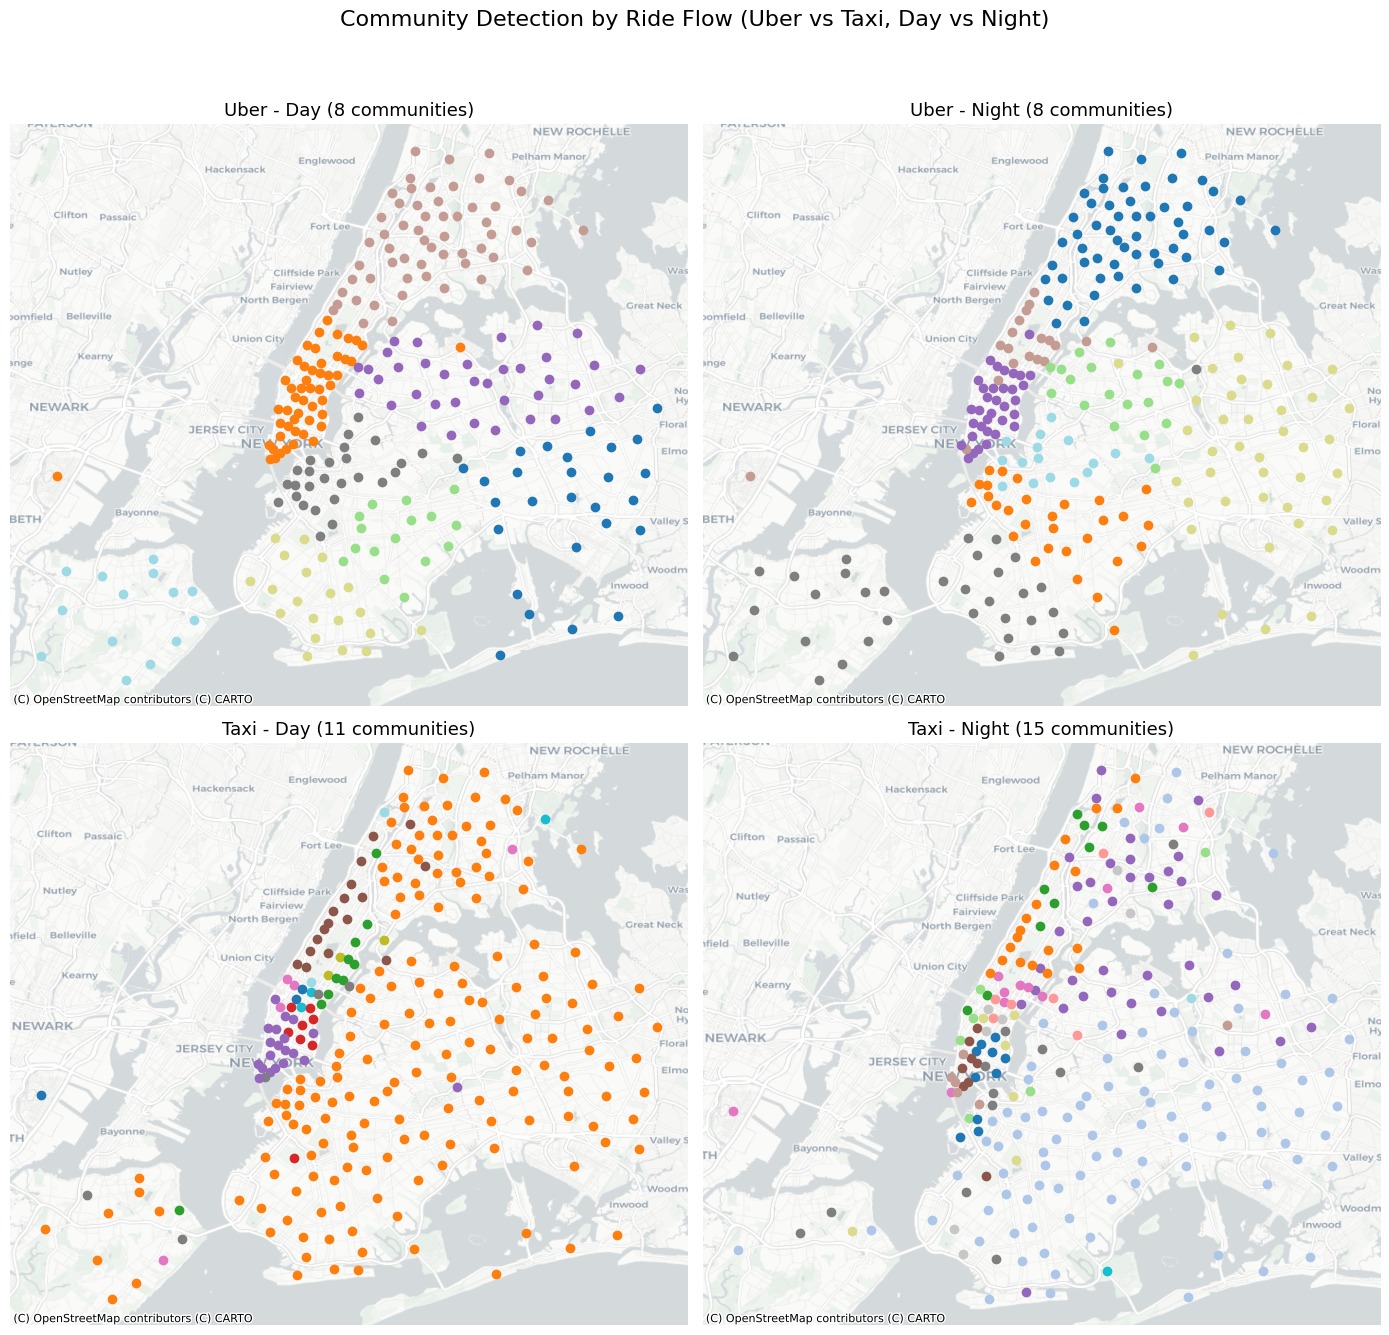

uber_day: 8 communities detected
uber_night: 8 communities detected
taxi_day: 11 communities detected
taxi_night: 15 communities detected


In [76]:
plot_communities({
    "Uber - Day": gdf_communities["uber_day"],
    "Uber - Night": gdf_communities["uber_night"],
    "Taxi - Day": gdf_communities["taxi_day"],
    "Taxi - Night": gdf_communities["taxi_night"]
})


# Print community count summary
for label, gdf in gdf_communities.items():
    num_comms = gdf["community"].nunique()
    print(f"{label}: {num_comms} communities detected")

**Findings**
* **Uber Rides:**
  - Both daytime and late-night communities align with borough boundaries, forming tight and geospatially cohesive clusters.
  - Communities are clearly delineated and largely intra-borough, suggesting limited cross-region rides.
* **Taxi Rides**
  - More fragmented and numerous communities, particularly during late-night, indicating a more diffuse trip pattern.
  - Weak spatial community boundary in Manhattan can be observed for daytime rides.
  - During daytime, Bronx, Queens, and Brooklyn appear within the same community, and at night, several Brooklyn and Queens zones cluster together. 
  - Spatial dispersion of taxi rides appears broader in boroughs outside Manhattan compared to Uber rides.

**Interpretation**
- Higher fragmentation in taxi night rides within Manhattan suggests more localized and diverse travel patterns. In contrast, taxi communities in outer boroughs (e.g., Brooklyn, Queens, Bronx) appear more spatially dispersed, indicating longer-distance or cross-neighborhood trips outside of Manhattan.
- Uber’s lower community count reflects broader zone groupings, aligning with app-based long-distance rides.
- Stable Uber communities imply consistent rider/driver behaviors, taxi rides may respond more dynamically to time and location.

#### 2.4 Ride Flow Investigations

This section is for reflecting ride flows within each directed graph (Uber vs Taxi, Day vs Night). Key features include:
- Whether origin and destination fall within the same community

- Whether trips are intra-zone (same origin & destination)

- Cross-zone central corridors and directional symmetry

In [77]:
def extract_normalized_edges(G: nx.DiGraph, partition: Optional[Dict[int, int]] = None) -> pd.DataFrame:
    """
    Extracts and normalizes edge weights from a directed graph G.

    Args:
        G (nx.DiGraph): Directed graph with zones as nodes and ride counts as edge weights.
        partition (Optional[Dict[int, int]], optional): _description_. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame with columns: "origin", "destination", "rides", "proportion", and optionally "same_community"
    """
    total_weight = sum(d['weight'] for _, _, d in G.edges(data=True))
    
    data = []
    for u, v, d in G.edges(data=True):
        row = {
            "origin": u,
            "destination": v,
            "rides": d["weight"],
            "proportion": d["weight"] / total_weight
        }
        if partition:
            row["same_community"] = partition.get(u) == partition.get(v)
        data.append(row)
    
    return pd.DataFrame(data).sort_values("rides", ascending=False)

In [78]:
edges_tables = {}

for name, G in graphs.items():
    gdf_comm = gdf_communities[name]

    partition = dict(zip(gdf_comm["zone_id"], gdf_comm["community"]))

    edges_tables[name] = extract_normalized_edges(G, partition)
    edges_tables[name]["origin_zone"] = edges_tables[name]["origin"].map(lambda x: ID_COORDS_DICT.get(x, {}).get("zone", "Unknown"))
    edges_tables[name]["destination_zone"] = edges_tables[name]["destination"].map(lambda x: ID_COORDS_DICT.get(x, {}).get("zone", "Unknown"))
    
    print(f"{name}: top 5 edges")
    print(edges_tables[name][["origin_zone", "destination_zone",
                             "rides", "proportion", "same_community"]].head(5))
    print("\n")

uber_day: top 5 edges
               origin_zone     destination_zone  rides  proportion  \
7381         East New York        East New York    401    0.003491   
6787              Canarsie             Canarsie    279    0.002429   
12852         Borough Park         Borough Park    247    0.002150   
12715            Bay Ridge            Bay Ridge    189    0.001645   
1011   Crown Heights North  Crown Heights North    183    0.001593   

       same_community  
7381             True  
6787             True  
12852            True  
12715            True  
1011             True  


uber_night: top 5 edges
              origin_zone     destination_zone  rides  proportion  \
7028        East New York        East New York     50    0.001840   
1490       Bushwick North       Bushwick South     49    0.001803   
1982  Crown Heights North  Crown Heights North     45    0.001656   
1598       Bushwick South       Bushwick South     43    0.001583   
1225              Astoria              Ast

**Uber rides**
- Daytime
    - Highly localized flows (self-loops) with strong intra-zone activity.
    - These zones are mostly in Brooklyn, suggesting short-distance movements in outer boroughs
    - Same-community tags reinforce Uber’s geo-contained clusters, likely optimized by demand-driven matching algorithms.
- Late night
    - Continuity of localized demand in the late-night period, and clusters reflect tight communities with limited cross-community flows.

**Taxi rides**
- Daytime
    - Dominance of Upper East Side flows: dense taxi activity in Manhattan’s residential and commercial areas.
    - Flows are directionally symmetric, suggesting commuting or repeated travel patterns.
    - Some cross-community flows to Midtown: higher zone interconnectivity than Uber and less self-loops within zones.
- Late night
    - Rides are more dispersed across communities, even in short distances.
    - Demand less centralized, and higher share of cross-community short trips in Manhattan.

### 3. Weather and Ridership

#### 3.1 Late-Night Ride Volumes vs. Precipitation

In [179]:
QUERY_RIDE_WEATHER_FILENAME = "ride_weather.sql"

QUERY_RIDE_WEATHER = """
-- hourly weather table
WITH weather AS (
    SELECT 
        DATE(date_hour) AS weather_date, 
        STRFTIME('%H', date_hour) AS hour,
        CASE
            WHEN CAST(STRFTIME('%H', date_hour) AS INTEGER) >= 22 
            OR CAST(STRFTIME('%H', date_hour) AS INTEGER) < 4 THEN 'late-night'
            ELSE 'daytime'
        END AS time_period,
        SUM(hourly_precipitation) AS total_precip,
        AVG(hourly_wind_speed) AS avg_wind
    FROM hourly_weather
    GROUP BY weather_date, hour
    ),

-- rides table
hourly_rides AS (
    SELECT 
        DATE(tpep_pickup_datetime) AS ride_date,
        STRFTIME('%H', tpep_pickup_datetime) AS hour,
        time_period,
        "taxi" AS source,
        COUNT(*) AS ride_count,
        ROUND(AVG(trip_distance), 2) AS avg_distance,
        ROUND(AVG(trip_time) / 60.0, 2) AS avg_duration,
        ROUND(AVG(total_amount), 2) AS avg_fare,
        ROUND(AVG(tip_amount), 2) AS avg_tip,
        ROUND(AVG(tip_amount/total_amount), 4) AS avg_tip_rate
    FROM taxi_trips
    GROUP BY ride_date, hour, source

    UNION ALL

    SELECT 
        DATE(pickup_datetime) AS ride_date,
        STRFTIME('%H', pickup_datetime) AS hour,
        time_period,
        "uber" AS source,
        COUNT(*) AS ride_count,
        ROUND(AVG(trip_miles), 2) AS avg_distance,
        ROUND(AVG(trip_time) / 60.0, 2) AS avg_duration,
        ROUND(AVG(total_fares), 2) AS avg_fare,
        ROUND(AVG(tips), 2) AS avg_tip,
        ROUND(AVG(tips/total_fares), 4) AS avg_tip_rate
    FROM uber_trips
    GROUP BY ride_date, hour, source
    )

SELECT 
    r.ride_date,
    r.hour,
    r.source,
    r.ride_count,
    r.avg_distance,
    r.avg_duration,
    r.avg_fare,
    r.avg_tip,
    avg_tip_rate,
    w.total_precip,
    w.avg_wind,
    w.time_period
FROM hourly_rides r
LEFT JOIN weather w
ON r.ride_date = w.weather_date AND r.hour = w.hour
ORDER BY r.ride_date, r.source, r.hour, w.time_period;
"""

df_ride_weather = pd.read_sql(QUERY_RIDE_WEATHER, con=engine)
write_query_to_file(QUERY_RIDE_WEATHER, QUERY_RIDE_WEATHER_FILENAME)

In [ ]:
df_ride_weather["precip_bin"] = pd.cut(
    df_ride_weather["total_precip"],
    bins=[-0.01, 0.01, 0.2, 0.7, 10],
    labels=["Dry", "Light", "Moderate", "Heavy"]
)

sample_counts = (
    df_ride_weather
    .groupby(["precip_bin", "time_period"], observed=True)
    .size()
    .reset_index(name="n")
)

print(sample_counts)

fig = px.box(
    df_ride_weather,
    x="precip_bin",
    y="ride_count",
    color="time_period",
    category_orders={
        "precip_bin": ["Dry", "Light", "Moderate", "Heavy"]
    },
    labels={
        "precip_bin": "Precipitation Intensity",
        "ride_count": "Hourly Ride Count",
        "time_period": "Time of Day"
    },
    title="Ride Count Distribution by Precipitation Intensity",
)
fig.show()

  precip_bin time_period      n
0        Dry     daytime  37771
1        Dry  late-night  10961
2      Light     daytime   2353
3      Light  late-night    628
4   Moderate     daytime    464
5   Moderate  late-night    186
6      Heavy     daytime    162
7      Heavy  late-night     45


**1. Daytime rides consistently show higher medians than late-night rides across all precipitation bins.**<br>

This is consistent with previous findings, that regardless of weather conditions, daytime demand is structurally stronger than late-night demand.

**2. Dry conditions display the greatest variation in ride counts, with the largest spread and more points outside the upper fence.** <br>

This is likely due to the much larger sample size in dry conditions compared to rainy conditions, which naturally introduces more variability.

**3. Increasing precipitation shows only a modest impact on ride counts.**<br>

As rainfall intensifies, ride count distributions shift moderately upward—particularly during the daytime—suggesting some substitution from walking or public transit to taxis or rideshare services. However, the overall effect remains limited. 

This may be explained by a dual behavior: while many individuals cancel non-essential trips during rain, reducing overall travel demand, others with unavoidable schedules are more likely to switch to rideshare options, offsetting the decline. This balancing effect results in only a mild net change in ride volume.